<font size="7"><b>Springboard Time Series:<br>Cowboy CigarettesCase Study - Tier 3</b></font>

# Introduction

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining.

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies.

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading**
- Load relevant libraries
- Load the data
- Explore the data


**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y`
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling**
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding**
- What is our conclusion?
- Next steps
    

# Preliminaries

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Dependencies

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# This import is no longer working!!
# import statsmodels.api as sm

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## 1.2. Customizations

In [3]:
# Suppresse (ignore) non-fatal warning messages
warnings.filterwarnings(
    "ignore"
)

## 1.3. Functions

### <b><code>plot_decomp_components()</code></b>

In [4]:
def plot_decomp_components(
      time_series
    , period           = 12
    , component_labels = ['#CigSales', 'Trend', 'Seasonality', 'Residuals']
):
    """
    Plots the components of time series decomposition using seasonal decomposition.

    Parameters:
        time_series (pandas.Series): The time series data to be decomposed.
        period (int, optional): The period of seasonality in the time series. Default is 12.
        component_labels (list of str, optional): Labels for the components to be displayed in subplots.
          Default is ['#CigSales', 'Trend', 'Seasonality', 'Residuals'].

    Returns:
        None
    """

    # Decompose the time series
    decomp = seasonal_decompose(
          time_series
        , period = period
    )

    # Create a figure with 4 subplots
    fig, axes = plt.subplots(
          len(component_labels)
        , 1
        , figsize = (len(component_labels)*1.5, len(component_labels))
        , sharex  = True
    )

    # Loop through axes and component labels
    for i, (ax, label) in enumerate(zip(axes, component_labels)):

        ax.set_ylabel(
            label
        )

        ax.grid(
              axis      = 'both'
            , linestyle = '--'
            , alpha     = 0.7
        )

        if i == 3:
            ax.set_xlabel(
                'Time'
            )

            ax.tick_params(
                  axis   = 'both'
                , which  = 'both'
                , left   = True
                , bottom = True
            )

        # Plot the corresponding component
        if i == 0:
            ax.plot(time_series)
        elif i == 1:
            ax.plot(decomp.trend)
        elif i == 2:
            ax.plot(decomp.seasonal)
        elif i == 3:
            if label == 'Residuals':
                ax.scatter(time_series.index, decomp.resid, marker='.', s=10, label='Residuals')
            else:
                ax.plot(decomp.resid)

    plt.tight_layout()
    plt.show()

### <b><code>kpss_test()</code></b>

In [5]:
def kpss_test(
    data_dict
):
    """
    Perform KPSS (Kwiatkowski-Phillips-Schmidt-Shin) stationarity test on multiple time series.

    Parameters:
    - data_dict (dict): A dictionary containing variable names as keys and corresponding time series data as values.

    Returns:
    - results_dict (dict): A dictionary with variable names as keys and KPSS test results as Pandas Series for each variable.
                          The series includes Test Statistic, p-value, Lags Used, and Critical Values.

    Example:
    >>> data_dict = {'Variable1': time_series1, 'Variable2': time_series2}
    >>> kpss_results = kpss_test(data_dict)
    >>> print(kpss_results)
    """

    # Set display width option to a larger value
    pd.set_option(
          'display.width'
        , 1000
    )

    results_dict = {}

    for data_name, data in data_dict.items():

        # Perform KPSS test on the time series data
        kpsstest = kpss(data)

        # Create a Pandas Series to store test results
        kpss_output = pd.Series(
              kpsstest[0:3]
            , index = ['Test Statistic', 'p-value', 'Lags Used']
        )

        # Add critical values to the series
        for key, value in kpsstest[3].items():
            kpss_output['Critical Value (%s)' % key] = value

        # Store the results in the dictionary
        results_dict[data_name] = kpss_output

    return results_dict

### <b><code>compare_original_and_transformed_data_and_display_kpss_results()</code></b>

In [6]:
def compare_original_and_transformed_data_and_display_kpss_results(
    data_dict
):
    """
    Create a DataFrame from a dictionary of data series.

    Args:
        data_dict (dict): A dictionary where keys are column names and values are data series.

    Returns:
        pd.DataFrame: A DataFrame containing the data series.
    """

    df = pd.DataFrame(
        data_dict
    )

    print(
        df
    )

    # Perform KPSS test for each variable in the dictionary
    kpss_results = kpss_test(
        data_dict
    )

    # Create a DataFrame from the results
    results_df = pd.DataFrame(
        kpss_results
    )

    # Display the results DataFrame with columns as variables
    print(
        '\n\n\nKPSS Test results:'
    )

    print(
        results_df
    )

### <b><code>analyze_and_plot_data()</code></b>

In [7]:
def analyze_and_plot_data(
      data_dict
    , window_size = 12
):
    """
    Analyze and plot rolling statistics for one or multiple time series variables.

    Parameters:
    - data_dict (dict): A dictionary containing variable names as keys and corresponding time series data as values.
    - window_size (int): The window size for calculating rolling statistics.

    Returns:
    - None: This function generates and displays plots.

    If only one variable is provided in data_dict, it plots the variable's
    data, rolling mean, rolling variance, and rolling covariance in separate
    subplots. If multiple variables are provided, it calculates and compares
    their rolling means, rolling variances, and rolling covariances.
    """

    # Check if there's only one variable in data_dict (usually original data)
    if len(data_dict) == 1:

        var_name, var_data = next(iter(data_dict.items()))

        # Calculate rolling statistics (mean, variance, covariance)
        rolling_mean = var_data.rolling(window=window_size).mean()
        rolling_var  = var_data.rolling(window=window_size).var()
        rolling_cov  = var_data.rolling(window=window_size).cov(var_data)

        # Create a figure with 4 subplots (data, rolling mean, rolling variance)
        fig, axes = plt.subplots(
              4
            , 1
            , figsize = (12, 8)
            , sharex  = True
            , gridspec_kw={'hspace': 0.6}
        )

        # Plot the variable data
        axes[0].plot(var_data, label=var_name)
        axes[0].set_title(f'{var_name}', size=18)
        axes[0].set_ylabel('#CigSales', size=12)

        # Plot the rolling mean
        axes[1].plot(rolling_mean, label='Rolling Mean')
        axes[1].set_ylabel('Rolling Means \n #CigSales', size=12)

        # Plot the rolling variance
        axes[2].plot(rolling_var, label='Rolling Variance')
        axes[2].set_ylabel('Rolling Variances \n #CigSales', size=12)

        # Plot the rolling covariance
        axes[3].plot(rolling_cov, label='Rolling Covariance')
        axes[3].set_ylabel('Rolling Covariances \n #CigSales', size=12)
        axes[3].set_xlabel('Time \n (Month)', size=14)
        axes[3].tick_params(axis='both', which='both', left=True, bottom=True)

        # Apply grid to all subplots
        for ax in axes:
            ax.grid(
                  True
                , alpha     = 0.7
                , linestyle = '--'
                , linewidth = 0.3
            )

        # Ensure tight layout
        plt.tight_layout()

        # Show the plots
        plt.show()
    # =========================================================================
    else:
      # Initialize rolling statistics DataFrame
      rolling_stats = pd.DataFrame()

      # Create a figure for subplots
      fig, axes = plt.subplots(
            len(data_dict)
          , 1
          , figsize = (len(data_dict)*3, 8)
          , sharex  = True
      )
      # -----------------------------------------------------------------------
      # Iterate through variables in data_dict
      for i, (var_name, var_data) in enumerate(data_dict.items()):

          # Calculate rolling statistics (mean, variance, covariance)
          rolling_mean = var_data.rolling(window=window_size).mean()
          rolling_var  = var_data.rolling(window=window_size).var()
          rolling_cov  = var_data.rolling(window=window_size).cov(var_data)

          # Store rolling statistics in the DataFrame
          rolling_stats[f'{var_name}_Mean'] = rolling_mean
          rolling_stats[f'{var_name}_Var']  = rolling_var
          rolling_stats[f'{var_name}_Cov']  = rolling_cov

          # Plot the variable in a separate subplot
          ax = axes[i]
          ax.set_title(f'{var_name}')

          if   'original' in var_name.lower():
            ax.set_ylabel(r'$\# CigSales$', size=14)
          elif 'log' in var_name.lower() and 'diff' not in var_name.lower():
            ax.set_ylabel(r'$\ln(\# CigSales)$', size=14)
          elif 'diff' in var_name.lower() and 'log' not in var_name.lower():
            ax.set_ylabel(r'$\Delta_{(\# CigSales)}$', size=20)
          elif 'diff' in var_name.lower() and 'log' in var_name.lower():
            ax.set_ylabel(r'$\Delta_{\ln(\# CigSales)}$', size=20)

          ax.plot(var_data)

          if i==len(data_dict.items()):
            ax.set_xlabel('Time \n (Month)', size=14)

      # Apply grid to all subplots
      for ax in axes:
          ax.grid(
                True
              , alpha     = 0.7
              , linewidth = 0.3
              , linestyle = '--'
          )
      # -----------------------------------------------------------------------
      # Create subplots for rolling statistics and compare them
      fig2, axes2 = plt.subplots(
            3
          , 1
          , figsize = (9, 8)
          , sharex  = True
      )

      # Plot the rolling means without suffix
      for var_name in data_dict.keys():
          axes2[0].plot(rolling_stats.index, rolling_stats[f'{var_name}_Mean'], label=var_name)
      # Plot the rolling variances without suffix
      for var_name in data_dict.keys():
          axes2[1].plot(rolling_stats.index, rolling_stats[f'{var_name}_Var'], label=var_name)
      # Plot the rolling covariances without suffix
      for var_name in data_dict.keys():
          axes2[2].plot(rolling_stats.index, rolling_stats[f'{var_name}_Cov'], label=var_name)


      # Set titles and labels for rolling statistics subplots
      axes2[0].set_ylabel('Rolling Means \n #CigSales', size=14)
      axes2[0].legend(loc='center left')
      axes2[1].set_ylabel('Rolling Variances \n #CigSales', size=14)
      axes2[1].legend()
      axes2[2].set_ylabel('Rolling Covariances \n #CigSales', size=14)
      axes2[2].legend()
      axes2[2].set_xlabel('Time \n (Month)', size=14)

      # Apply grid to rolling statistics subplots
      for ax in axes2:
          ax.grid(
                True
              , alpha     = 0.7
              , linewidth = 0.3
              , linestyle = '--'
          )
      # -----------------------------------------------------------------------
      # Ensure tight layout
      plt.tight_layout()

      # Show the plots
      plt.show()

---

# 2. Load

Read the dataset and store it in a variable called <b><code>cigData</code></b> .

In [8]:
file_path = "/content/drive/MyDrive/Colab Notebooks/data/21.1.CowboyCigsData.csv"

In [9]:
cigData = pd.read_csv(
      file_path
)

In [10]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [11]:
cigData.tail()

,Unnamed: 0,Time,#CigSales
139,139,1960-08,1000606
140,140,1960-09,1000508
141,141,1960-10,1000461
142,142,1960-11,1000390
143,143,1960-12,1000432


---

# 3. EDA

We now need to check whether the data conduces to a time series style analysis.

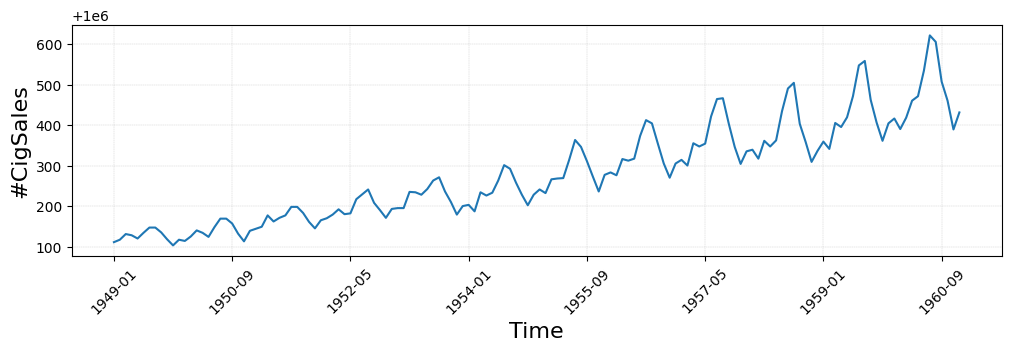

In [12]:
f,ax = plt.subplots(
    figsize = (12, 3)
)

cigData.plot(
      x  = 'Time'
    , y  = '#CigSales'
    , ax = ax
)

# Orient x-axis labels at a 45-degree angle
ax.set_xticklabels(
      ax.get_xticklabels()
    , rotation = 45
)

ax.grid(
      True
    , alpha     = 0.7
    , linestyle = '--'
    , linewidth = 0.3
)

ax.set_xlabel(
      'Time'
    , size = 16
)

ax.set_ylabel(
      '#CigSales'
    , size = 16
)

ax\
.legend()\
.set_visible(False)

plt.show()

> <font color="darkgrey" size="3">
> The fluctuations in the line indicate changes in cigarette sales over time. The data appears to be collected at regular intervals, which is characteristic of time series data.
</font>

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand.

Check out the columns feature of the data. How many columns are there?

In [13]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [14]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values.

In [15]:
cigData\
.isnull()\
.sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

<font size="5">Cleaning, Transforming, and Visualizing</font>

## 3.1. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [16]:
cigData.drop(
      columns = ["Unnamed: 0"]
    , inplace = True
)

In [17]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


## 3.2. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [18]:
cigData.rename(
      columns = {'Time':'Month'}
    , inplace = True
)

In [19]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


## 3.3. Type conversions

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [20]:
cigData['Month'] = cigData['Month'].apply(pd.to_datetime)
cigData.head()

,Month,#CigSales
0,1949-01-01,1000112
1,1949-02-01,1000118
2,1949-03-01,1000132
3,1949-04-01,1000129
4,1949-05-01,1000121


Set the <b><code>'Month'</code></b> column as the index and the structure of DataFrame <b><code>cigData</code></b> .

In [21]:
cigData = cigData.set_index('Month')
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


## 3.4. Target Variable

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column.

In [22]:
y = cigData['#CigSales']
y

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: #CigSales, Length: 144, dtype: int64

Check the type of our new variable.

In [23]:
type(y)

pandas.core.series.Series

## 3.5. Summary Statistics

Get the summary statistics of our target variable.

In [24]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

## 3.6. Visualize

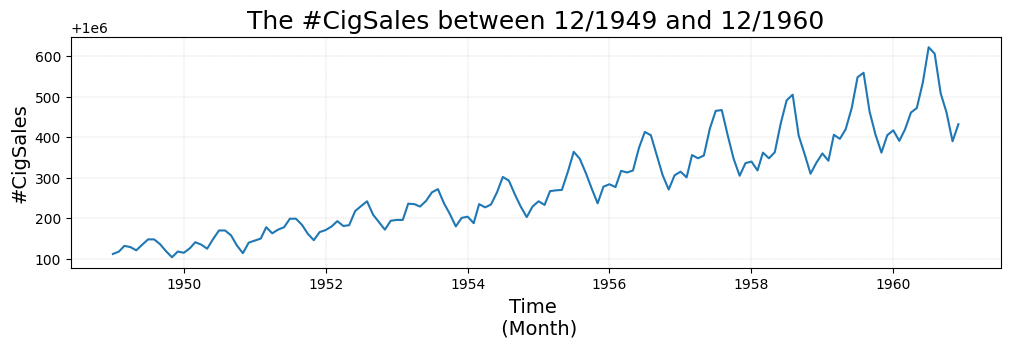

In [25]:
fig, ax = plt.subplots(
    figsize = (12, 3)
)

ax.grid(
      True
    , alpha     = 0.7
    , linestyle = '--'
    , linewidth = 0.3
)

ax.set_title('The #CigSales between 12/1949 and 12/1960', size=18)
ax.set_xlabel('Time \n (Month)', size=14)
ax.set_ylabel('#CigSales', size=14)

ax.plot(y)

plt.show()

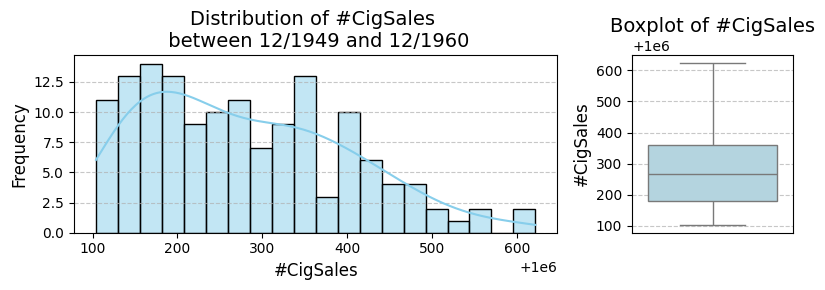

In [26]:
# Create a figure with two horizontal subplots
fig, axes = plt.subplots(
      1
    , 2
    , figsize     = (8, 3)
    , gridspec_kw = {'width_ratios': [3, 1]}
)
# =============================================================================
#                  Subplot 1 - Distribution plot (histogram)
# =============================================================================
sns.histplot(
      y
    , bins  = 20
    , kde   = True
    , ax    = axes[0]
    , color = 'skyblue'
)

axes[0].set_title(
      'Distribution of #CigSales \n between 12/1949 and 12/1960'
    , fontsize = 14
)

axes[0].set_xlabel(
      '#CigSales'
    , fontsize = 12
)

axes[0].set_ylabel(
      'Frequency'
    , fontsize = 12
)

axes[0].tick_params(
      axis      = 'both'
    , labelsize = 10
)

axes[0].grid(
      axis      = 'y'
    , alpha     = 0.7
    , linestyle = '--'
)
# =============================================================================
#                            Subplot 2 - Boxplot
# =============================================================================
sns.boxplot(
      y
    , ax    = axes[1]
    , color = 'lightblue'
)

axes[1].set_title(
      'Boxplot of #CigSales'
    , fontsize = 14
)

# Remove xlabel and xticks
axes[1].set_xlabel(
      ''
    , fontsize = 12
)

axes[1].set_xticks(
    []
)

axes[1].set_ylabel(
      '#CigSales'
    , fontsize = 12
)

axes[1].tick_params(
      axis      = 'both'
    , labelsize = 10
)

axes[1].grid(
      axis      = 'y'
    , alpha     = 0.7
    , linestyle = '--'
)

# Ensure tight layout for aesthetics
plt.tight_layout()

# Show the subplots
plt.show()

---

# 4. Modelling

## 4.1. Decomposition

What do you notice from the plot? Take at least 2 minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to $\small\textbf{decompose}$ time series data? It means breaking that data into 3 components:

1. <b>Trend</b>: The overall direction that the data is travelling in (like upwards or downwards)
2. <b>Seasonality</b>: Cyclical patterns in the data
3. <b>Noise</b> (AKA <b>irregresidualular</b> or <b>irregular</b>): The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model.

Make a coffee, take 5 minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here:

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative.

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

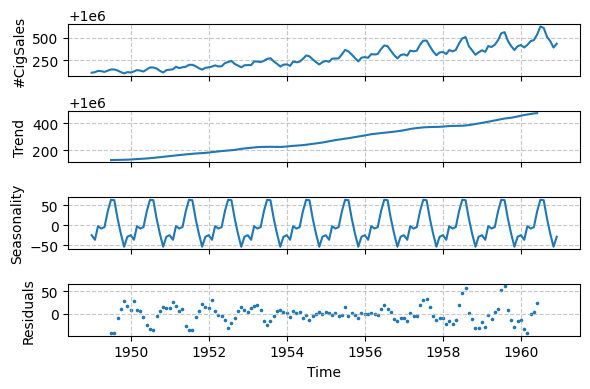

In [27]:
plot_decomp_components(
    y
)

### Conclusions

> <font color="grey" size="3">
> <ol start="1">
> <li><b>Trend:</b></li>
> <font color="grey" size="3">
>
> <font color="grey" size="3"><ul><li> The trend component shows a clear upward trend over time, indicating that cigarette sales were consistently increasing throughout the decade.</ul></li></font>
>
> <font color="grey" size="3"><ul><li> The upward slope suggests that either more people were starting to smoke, people who already smoked were consuming more, or a combination of both factors.</ul></li></font>
>
> </ul></ol>
> <font color="grey" size="3">
> <ol start="2"><li><b>Seasonal:</b></li>
>
> <font color="grey" size="3"><ul><li> The seasonal component demonstrates a repeating pattern within each year, which implies that cigarette sales experienced regular fluctuations that correspond to specific times of the year.</ul></li>
>
> <font color="grey" size="3"><ul><li> This could be due to various seasonal factors, such as holidays, social events, or weather conditions that could influence smoking habits.</ul></li>
>
> </ul></ol>
> <font color="grey" size="3"><ol start="3">
>
> <li><b>Residual:</b></li>
>
> <font color="grey" size="3"><ul><li> The residual, or irregular component, represents the noise after the trend and seasonal effects have been removed from the original data.</ul></li>
>
> <font color="grey" size="3"><ul><li> This part of the decomposition captures the random variations that are not explained by the trend or seasonal components.</ul></li>
>
> <font color="grey" size="3"><ul><li> Based on the graph above, the residuals appear to be relatively stable and scattered around zero, suggesting that the trend and seasonal components have been successfully captured, leaving behind only the unexplained variance in the sales data.</ul></li>
> </ul></ol></font>
> Overall, the decomposition indicates that the cigarette sales data have a strong and increasing trend, a significant seasonal pattern, and relatively small random fluctuations that could not be explained by the trend or seasonal components. Understanding these components can help in :
>  <li> Forecasting future sales
>  <li> Adjusting for seasonal patterns
>  <li> Identifying any unusual changes that might require further investigation

## 4.2. No transformation

As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

\begin{align}
\end{align}
> <font color="grey" size="3">
> <ol start="1">
> <li><b><font color="grey" size="4">Null Hypothesis ($H_0$)</font></b></li>
> <font color="grey" size="3">
>
> <font color="grey" size="3"><ul><li> The null hypothesis of the KPSS test is that the series is <b>stationary around a deterministic trend.</b></ul></li></font>
>
> <font color="grey" size="3"><ul><li> If the $\text{p-value}$ is <b>greater than</b> the chosen $\text{significance level}$ (typically, $\alpha=0.05$), we would <b>fail to reject</b> the null hypothesis, indicating that the series is stationary around a trend.</ul></li></font>
>
> </ul></ol>
> <font color="grey" size="3">
> <ol start="2"><li><b><font color="grey" size="4">Alternative Hypothesis ($H_1$)</font></b></li>
>
> <font color="grey" size="3"><ul><li> The alternative hypothesis is that the series is <b>non-stationary.</b></ul></li>
>
> <font color="grey" size="3"><ul><li> If the $\text{p-value}$ is <b>less than or equal</b> to the $\text{significance level}$ , we would <b>reject</b> the null hypothesis in favor of the alternative hypothesis, indicating that the series is <b>non-stationary.</b></ul></li>
> <br>$
\large{\text{Hypothesis Test Decision: }
\begin{cases}
\text{Fail to Reject } H_0 & \text{if } \text{p-value} > \text{significance level} \, (\alpha)\\
\text{Reject } H_0 & \text{if } \text{p-value} \leq \text{significance level} \, (\alpha)
\end{cases}}
$
> <br><br>
>
> </ul></ol>

### Compute

In [28]:
# Create a dictionary with variable names and corresponding data
data_dict = {
      'Original Data' : y
}

### Testing for stationarity

In [29]:
compare_original_and_transformed_data_and_display_kpss_results(
    data_dict
)

            Original Data
Month                    
1949-01-01        1000112
1949-02-01        1000118
1949-03-01        1000132
1949-04-01        1000129
1949-05-01        1000121
...                   ...
1960-08-01        1000606
1960-09-01        1000508
1960-10-01        1000461
1960-11-01        1000390
1960-12-01        1000432

[144 rows x 1 columns]



KPSS Test results:
                       Original Data
Test Statistic              1.651312
p-value                     0.010000
Lags Used                   8.000000
Critical Value (10%)        0.347000
Critical Value (5%)         0.463000
Critical Value (2.5%)       0.574000
Critical Value (1%)         0.739000


### Visualize

Let's recall how the target variable <b><code>y=cigData['#CigSales']</code></b> looks like over <b><code>Time</code></b> .

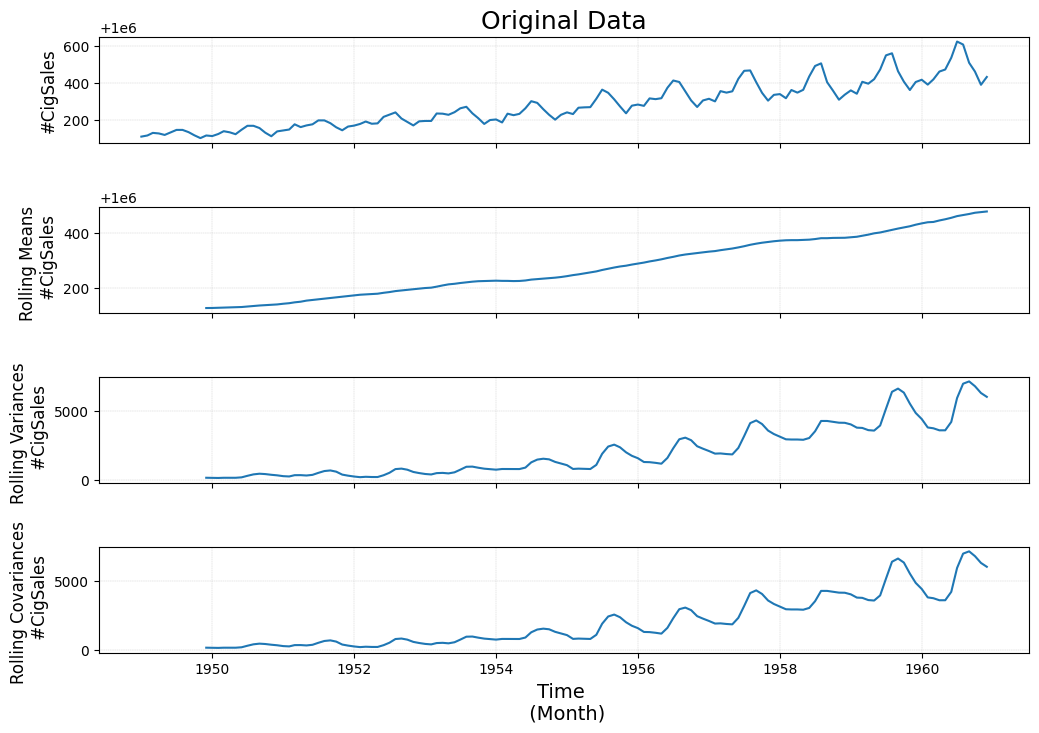

In [30]:
analyze_and_plot_data(
    data_dict
)

> <font color="grey" size="3">
> In our plot, we can see that both the mean and the variance <b>increase as time progresses</b>. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant?!).

### Conclusions

> <font color="grey" size="3">
> <li> The <font size="4"><b><code>p-value</code></b></font> (<font size="4"><b><code>0.010000</code></b></font>) is less than a typical significance level of <font size="4"><b><code>0.05</code></b></font> . This suggests that we would reject the null hypothesis ($H_0$) in favor of the Alternative Hypothesis ($H_1$).
> <br><br>
> <font color="grey" size="3">
> <li> The test statistic (<font size="4"><b><code>1.651312</code></b></font>) exceeds the critical values for all significance levels, including $10\%$, $5\%$, $2.5\%$, and $1\%$. This further supports the conclusion that the series is non-stationary.
> <br><br>
> <font color="grey" size="3">
> <li> The KPSS test indicates that our time series is non-stationary. In many time series analysis and modeling techniques, working with stationary data is preferred because it simplifies modeling assumptions and makes predictions more reliable.
> <br><br>
> <font color="grey" size="3">
> <li> Therefore, making our data stationary is necessary before applying time series models or techniques such as the ARIMA model. This can often involve:<br>
> 1. Differencing the data ; or<br>
> 2. Applying other transformations to remove trends or seasonality

## 4.3. Transformation I

One of the  used way of getting rid of changing variance is to take the natural log (using $\ln$ or <b><code>np.log()</code></b> ) of all the values in our dataset. Let's do this now.

### Compute

In [31]:
# Create a dictionary with variable names and corresponding data
data_dict = {
      'Original Data'        : y
    , 'Log-Transformed Data' : np.log(y)
}

### Testing for stationarity

In [32]:
compare_original_and_transformed_data_and_display_kpss_results(
    data_dict
)

            Original Data  Log-Transformed Data
Month                                          
1949-01-01        1000112             13.815623
1949-02-01        1000118             13.815629
1949-03-01        1000132             13.815643
1949-04-01        1000129             13.815640
1949-05-01        1000121             13.815632
...                   ...                   ...
1960-08-01        1000606             13.816116
1960-09-01        1000508             13.816018
1960-10-01        1000461             13.815971
1960-11-01        1000390             13.815900
1960-12-01        1000432             13.815942

[144 rows x 2 columns]



KPSS Test results:
                       Original Data  Log-Transformed Data
Test Statistic              1.651312              1.651332
p-value                     0.010000              0.010000
Lags Used                   8.000000              8.000000
Critical Value (10%)        0.347000              0.347000
Critical Value (5%)         0.46300

### Visualize


When we plot <b><code>np.log(y)</code></b> , the variance remains contant over time instead of increasing as we when plotting in <b><code>y</code></b> .

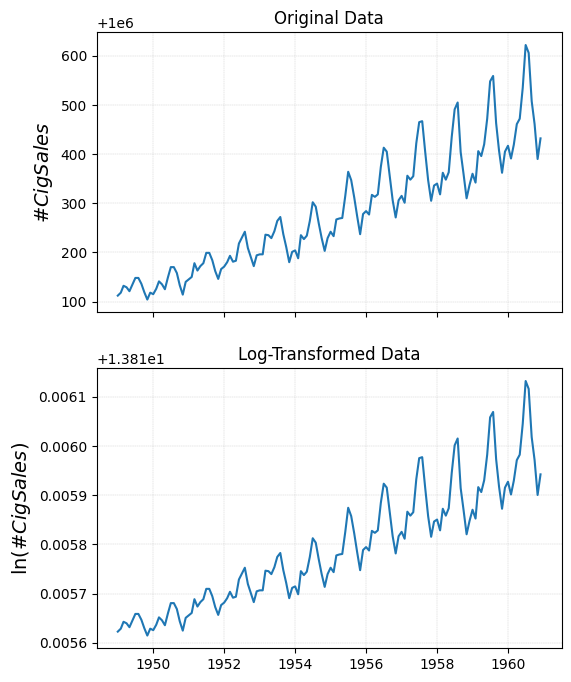

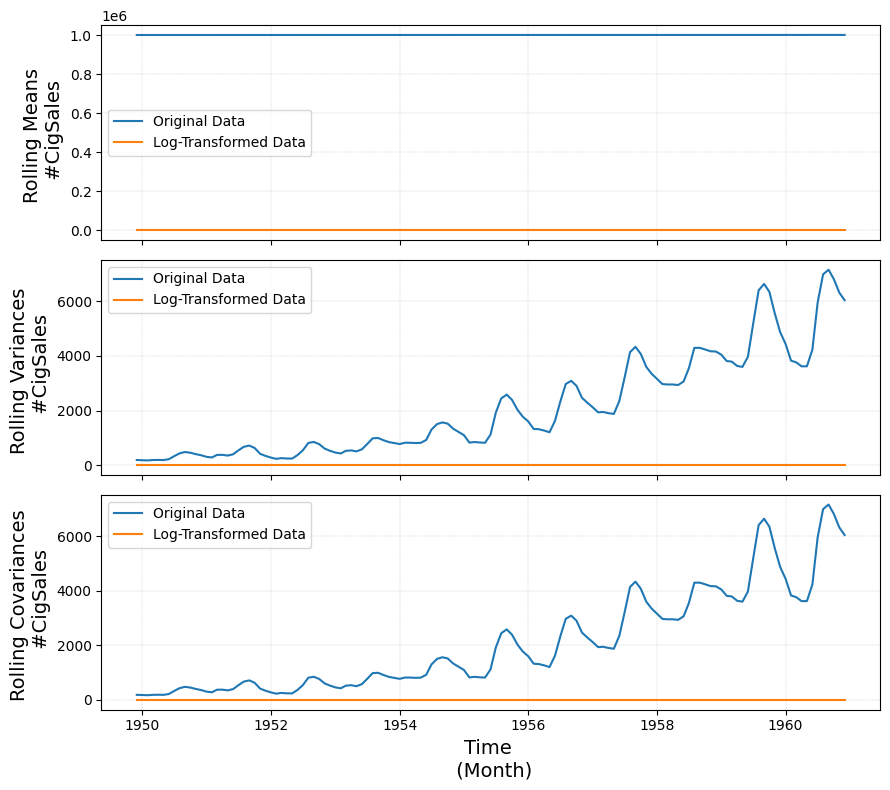

In [33]:
analyze_and_plot_data(
    data_dict
)

> <font color="grey" size="3">
> The bottom plot shows the variance of the original and log-transformed data <font size="4"><b><code>#CigSales</code></b></font> over time. It is clear that the transformed series is constant over time. However, the presence of a trend or cyclical behavior in the variance can still be present in the data. To check this, again, we will perform the KPSS Test.

### Colculsions

> <font color="grey" size="3">
> <b>To stabilize the variance, we took the natural logarithm of the target variable <font size="4"><b><code>y</code></b></font> (or column <font size="4"><b><code>#CigSales</code></b></font> ). Based on the results obtained from the KPSS test we can colculde that :</b>
> <br><br>
> <li> The <font size="4"><b><code>p-value</code></b></font> still remains at <font size="4"><b><code>0.010000</code></b></font> which is again below the conventional significance level of <font size="4"><b><code>0.05</code></b></font> for rejecting the null hypothesis. This suggests that we would reject the null hypothesis ($H_0$) and we conclude that our time series is still not stationary.
> <br><br>
> <font color="grey" size="3">
> <li> Again, the KPSS <font size="4"><b><code>Test Statistic</code></b></font> (<font size="4"><b><code>1.651312</code></b></font>) exceeds the critical values for all significance levels, including $10\%$, $5\%$, $2.5\%$, and $1\%$. Hence, would reject the null hypothesis of stationarity at all these levels.
> <br><br>
> While the transformation may have helped to make the variance more constant over time, there might still be a trend component in the data that needs to be addressed to achieve stationarity. We might need to consider $\small\textbf{detrending}$ the series or $\small\textbf{differencing}$ it to remove any underlying trend or seasonality before applying the KPSS test again.


## 4.4. Transformation II

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the <b><code>diff()</code></b> function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

### Compute

In [34]:
data_dict = {
      'Original Data'                    : y
    , 'Log-Transformed Data'             : np.log(y)
    , 'Differenced Data'                 : y.diff().dropna()
    , 'Log-Transformed Differenced Data' : (np.log(y)).diff().dropna()
}

### Testing for stationarity

In [35]:
compare_original_and_transformed_data_and_display_kpss_results(
    data_dict
)

            Original Data  Log-Transformed Data  Differenced Data  Log-Transformed Differenced Data
Month                                                                                              
1949-01-01        1000112             13.815623               NaN                               NaN
1949-02-01        1000118             13.815629               6.0                          0.000006
1949-03-01        1000132             13.815643              14.0                          0.000014
1949-04-01        1000129             13.815640              -3.0                         -0.000003
1949-05-01        1000121             13.815632              -8.0                         -0.000008
...                   ...                   ...               ...                               ...
1960-08-01        1000606             13.816116             -16.0                         -0.000016
1960-09-01        1000508             13.816018             -98.0                         -0.000098


### Visualize

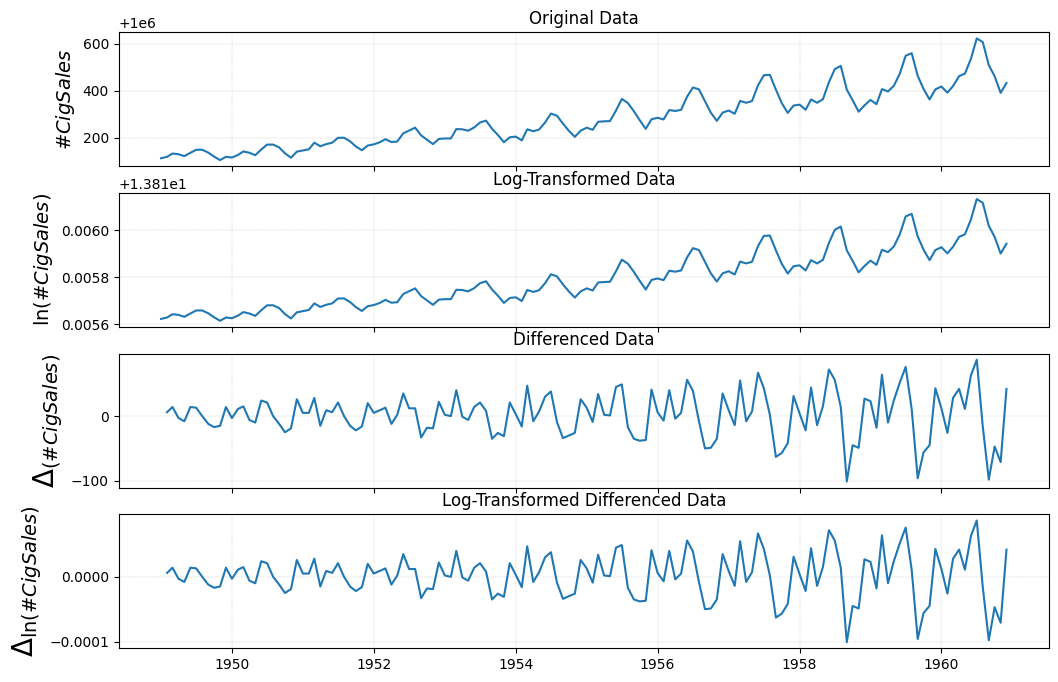

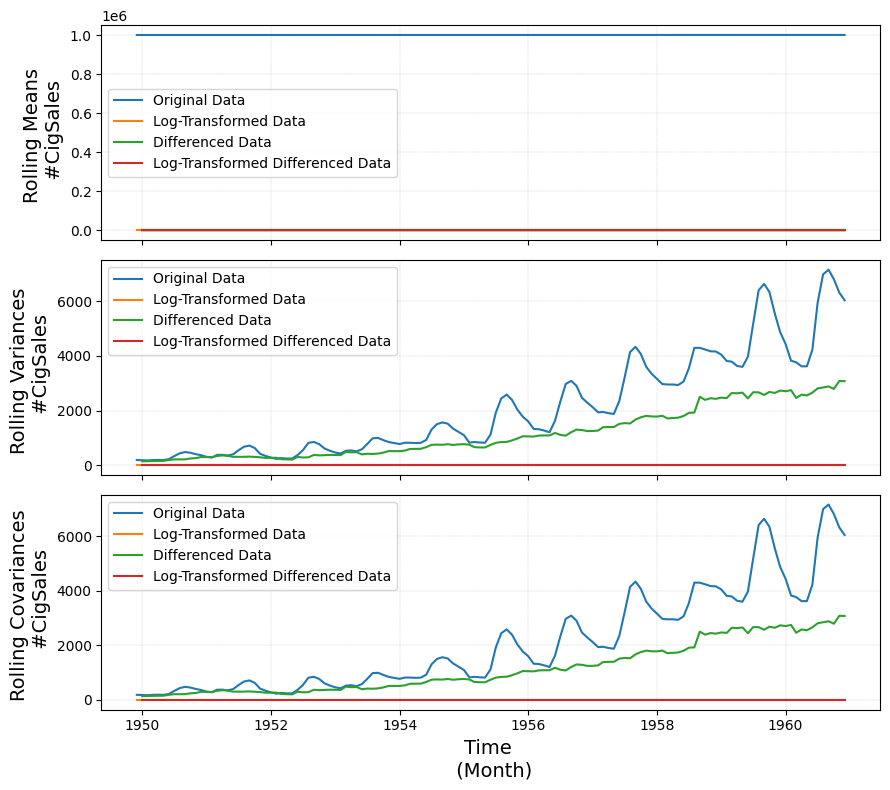

In [36]:
analyze_and_plot_data(
    data_dict
)

> <font color="grey" size="3">
> The transformations applied (log and differencing) seem to have successfully stabilized the variance and mean, making the data more suitable for modeling with ARIMA or other time series models. The goal of such transformations is typically to meet the assumptions of stationarity required by many time series models.

> <font color="grey" size="3">
> <font color="black" size="3"><b>NOTE:</b><br><font color="grey" size="3"> The combination of both logarithm and differencing (i.e., <b><code>np.log(<i>target_variable</i>).diff().dropna()</code></b> ) transformations is often done to stabilize the variance and achieve stationarity in both variance and mean.

### Conculsions

> <font color="grey" size="3">
><b>After differencing the sequential values of the log-transformed data or <font size="4"><b><code>np.log(y)</code></b></font> :</b>
> <br><br>
> <li> The <font size="4"><b><code>p-value</code></b></font> has now shifted to <font size="4"><b><code>0.100000</code></b></font> , surpassing the conventional significance threshold of <font size="4"><b><code>0.05</code></b></font> required for null hypothesis rejection. This indicates that we are now in a position to accept the null hypothesis ($H_0$) and assert that our time series exhibits stationarity.
> <br><br>
> <li> Additionally, the KPSS <font size="4"><b><code>Test Statistic</code></b></font> (<font size="4"><b><code>0.023898</code></b></font>) is lower than the critical thresholds associated with all significance levels, including $10\%$, $5\%$, $2.5\%$, and $1\%$. This further confirms the stationarity of our data after applying these transformation (natural logarithm and differencing).
> <br><br>
> By achieving data stationarity, there is no longer a necessity for further transformations. Therefore, we can proceed with developing a Time Series model to analyze our data.

## 4.5. Model (ARIMA)

### Hyperparameter Tuning

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the <b><code>sklearn</code></b> and <b><code>statsmodels </code></b> libraries, and in particular <b><code>mean_squared_error</code></b> and <b><code>ARIMA</code></b> .

Now, let's calculate MSE of a single ARIMA model. Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier.

In [37]:
def evaluate_arima_model(
      time_series
    , order
):

    """
    Evaluate an ARIMA model's performance.

    Parameters:
        time_series (array-like): Time series data.
        order (tuple): ARIMA model order (p, d, q).

    Returns:
        float: Mean squared error between predicted and actual values.
    """

    # Split the time series into train and test
    split = int(len(time_series) * 0.8)
    train, test = time_series[:split], time_series[split:]

    # Initialize a list to store past values
    past = [x for x in train]

    # Initialize a list to store predictions
    predictions = []

    # Iterate through test data
    for i in range(len(test)):
        try:
            # Fit an ARIMA model with given order
            model = ARIMA(past, order=order)
            model_fit = model.fit(method_kwargs={"warn_convergence": False})

            # Make one-step ahead prediction
            future = model_fit.forecast()[0]
            predictions.append(future)

            # Update the past list with the actual test value
            past.append(test[i])
        except Exception as e:
            print(f"Error in time step {i}: {e}")

    # Calculate the mean squared error
    mse = mean_squared_error(test, predictions)

    return mse

In [38]:
def evaluate_models(
      data
    , p_values
    , d_values
    , q_values
):

    """
    Evaluate combinations of p, d, and q values for an ARIMA model.

    Parameters:
        data (pandas.Series): Time series data.
        p_values (list): List of p values to try.
        d_values (list): List of d values to try.
        q_values (list): List of q values to try.

    Returns:
        Tuple: Best ARIMA configuration (p, d, q) and the corresponding Mean Squared Error (MSE).

    Example:
        p_values = [0, 1, 2]
        d_values = [0, 1]
        q_values = [0, 1, 2]
        best_config, best_score = evaluate_models(data, p_values, d_values, q_values)
    """

    best_cfg   = None
    best_score = float("inf")

    for p in p_values:
        for d in d_values:
            for q in q_values:

                order = (p, d, q)

                # Attempt to evaluate the ARIMA model with the given
                # configuration order (p, d, q)
                try:
                    mse = evaluate_arima_model(
                          data
                        , order
                    )

                    # If the calculated 'mse' is better (lower) than the current
                    # 'best_score', update the 'best_score' and configuration
                    if mse < best_score:
                        best_cfg   = order
                        best_score = mse

                    # Print the 'mse' for the current ARIMA configuration
                    print('ARIMA%s MSE=%.10f' % (order, mse))

                except:
                    continue


    return best_cfg, best_score

In [39]:
# Create search grids for each hyperparameter
p = d = q = list(range(0,3))
p, d, q

([0, 1, 2], [0, 1, 2], [0, 1, 2])

In [40]:
# Evaluate the stationary data (i.e., log-transformed differenced data)
best_result = evaluate_models(
      (np.log(y)).diff().dropna()
    , p
    , q
    , d
)

ARIMA(0, 0, 0) MSE=0.0000000028
ARIMA(0, 0, 1) MSE=0.0000000025
ARIMA(0, 0, 2) MSE=0.0000000026
ARIMA(0, 1, 0) MSE=0.0000000037
ARIMA(0, 1, 1) MSE=0.0000000036
ARIMA(0, 1, 2) MSE=0.0000000033
ARIMA(0, 2, 0) MSE=0.0000000081
ARIMA(0, 2, 1) MSE=0.0000000051
ARIMA(0, 2, 2) MSE=0.0000000081
ARIMA(1, 0, 0) MSE=0.0000000025
ARIMA(1, 0, 1) MSE=0.0000000025
ARIMA(1, 0, 2) MSE=0.0000000023
ARIMA(1, 1, 0) MSE=0.0000000037
ARIMA(1, 1, 1) MSE=0.0000000033
ARIMA(1, 1, 2) MSE=0.0000000033
ARIMA(1, 2, 0) MSE=0.0000000063
ARIMA(1, 2, 1) MSE=0.0000000050
ARIMA(1, 2, 2) MSE=0.0000000078
ARIMA(2, 0, 0) MSE=0.0000000025
ARIMA(2, 0, 1) MSE=0.0000000023
ARIMA(2, 0, 2) MSE=0.0000000023
ARIMA(2, 1, 0) MSE=0.0000000037
ARIMA(2, 1, 1) MSE=0.0000000035
ARIMA(2, 1, 2) MSE=0.0000000034
ARIMA(2, 2, 0) MSE=0.0000000063
ARIMA(2, 2, 1) MSE=0.0000000056
ARIMA(2, 2, 2) MSE=0.0000000076


In [41]:
# Print the best result
print(f"Best ARIMA Configuration (p, d, q): {best_result[0]}")
print(f"Best ARIMA MSE: {best_result[1]}")

Best ARIMA Configuration (p, d, q): (2, 0, 1)
Best ARIMA MSE: 2.2734460387766375e-09


The best ARIMA model configuration is <b><code>(2, 0, 1)</code></b> with a mean squared error (MSE) of approximately <b><code>2.27e-09</code></b> . This configuration achieved the lowest prediction error among the models evaluated, making it the most accurate choice for forecasting the given time series data.

### Create

In [42]:
# Extract the best ARIMA configuration (p, d, q) from best_result
best_p, best_d, best_q = best_result[0]

# Create and fit the ARIMA model with the best configuration
model = ARIMA(
      endog = (np.log(y)).diff().dropna()
    , order = (best_p, best_d, best_q)
)

### Fit

In [43]:
model_fit = model.fit()

### Forecast

In [44]:
# Make a forecast for the next 24 time steps (adjust the number as needed)
forecast = model_fit.forecast(
    steps = 24
)

We can take a look at a summary of the model this library has built around our data.

### Summary

In [45]:
summary_str = str(
    model_fit.summary()
)

print("\nARIMA Model Summary:\n")
print(summary_str)


ARIMA Model Summary:

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1287.929
Date:                Sat, 03 Feb 2024   AIC                          -2565.858
Time:                        21:30:51   BIC                          -2551.043
Sample:                    02-01-1949   HQIC                         -2559.838
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e-06   1.92e-06      0.705      0.481   -2.41e-06    5.12e-06
ar.L1          1.0672   1.88e-11   5.66e+10      0.000       1.067       1.067
ar.L2         -0.4449    2.4e

<br>
\begin{align}
\end{align}
<table>
  <tr>
    <td><font size="4"><b><code>Dep. Variable</code></b></td>
    <td><font size="3">This is the variable we are trying to predict, which is <b><code>#CigSales</code></b> in this case.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>No. Observations</code></b></td>
    <td><font size="3">There are <b><code>144</code></b> observations in the dataset.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Model</code></b></td>
    <td><font size="3">The ARIMA Model Order is specified as <b><code>ARIMA(2, 0, 1)</code></b> , indicating that it has:<br>- <b><code>2</code></b> AutoRegressive (AR) terms<br>- <b><code>0</code></b> differencing (I) term<br>-  <b><code>1</code></b> Moving Average (MA) term</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Log Likelihood</code></b></td>
    <td><font size="3">- A measure of how well the model fits the data.<br>- A higher log likelihood value indicates a better fit.</font></td>
  </tr>
  <tr>
    <td><font size="3">Akaike Information<br>Criterion</font><br><font size="4"><b><code>(AIC)</code></b></td>
    <td><font size="3">- It is a measure used for model selection.<br>- It quantifies the trade-off between the goodness of fit and the complexity of the model.<br>- Lower values of AIC suggest a better-fitting model.</font></td>
  </tr>
  <tr>
    <td><font size="3">Bayesian Information<br>Criterion</font><br><font size="4"><b><code>(BIC)</code></b></td>
    <td><font size="3">- Another measure used for model selection.<br>- Like <b><code>AIC</code></b> , it balances model fit and complexity, but it places a higher penalty on the number of parameters in the model.<br>- Lower values of <b><code>BIC</code></b> suggest a better-fitting model.</font></td>
  </tr>
  <tr>
    <td><font size="3">Hannan-Quinn Information<br>Criterion</font><br><font size="4"><b><code>(HQIC)</code></b></td>
    <td><font size="3">- Another measure used for model selection.<br>- It is designed to balance the goodness of fit and the complexity of a model while also considering the sample size.<br>- It is particularly useful when dealing with smaller sample sizes and can help in selecting a model that generalizes well.<br>- Similar to AIC and BIC, lower HQIC values indicate a better-fitting model.<br>$HQIC = -2 \cdot \text{log-likelihood} + 2 \cdot k \cdot \text{log}(\text{log}(n))$<br>$\text{log-likelihood}$: The log-likelihood of the model.<br>$k$: The number of estimated parameters in the model.<br>$n$: The sample size.</font></td>
  </tr>  
  <tr>
    <td><font size="4"><b><code>Coefficients</code></b></td>
    <td><font size="3">- The coefficients for the AutoRegressive (AR) and Moving Average (MA) terms are listed under <b><code>ar.L1</code></b> , <b><code>ar.L2</code></b> , and <b><code>ma.L1</code></b> .<br>- These coefficients represent the strength and direction of the relationships between the current value and lagged values of the time series data.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Sigma2</code></b></td>
    <td><font size="3">- It represents the estimated variance of the error term (residuals) in the model.<br>- In this case, it is a very small value, suggesting that the model has a low level of residual error.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Ljung-Box (Q)</code></b><br></td>
    <td><font size="3">- This statistic tests for autocorrelation in the residuals.<br>- In this case, it has a value of <b><code>0.72</code></b>, and the associated p-value is <b><code>0.40</code></b>, indicating that there is no significant autocorrelation in the residuals.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Jarque-Bera (JB)</code></b></td>
    <td><font size="3">- This statistic tests for normality in the residuals.<br>- In this case, it has a value of <b><code>0.63</code></b>, and the associated p-value is <b><code>0.73</code></b>, indicating that the residuals are approximately normally distributed.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Heteroskedasticity (H)</code></b><br></td>
    <td><font size="3">A value of <b><code>H=7.95</code></b> suggests that there may be some heteroskedasticity in the residuals.</font></td>
  </tr>
  <tr>
    <td><font size="4"><b><code>Kurtosis</code></b></td>
    <td><font size="3">The <b><code>Kurtosis</code></b> provides information about the shape of the distribution of residuals and a value of <b><code>3.14</code></b> suggests a normal distribution.</font></td>
  </tr>
</table>

<br>Overall, this <b><code>ARIMA(2, 0, 1)</code></b> model appears to fit the data reasonably well, as indicated by the <b><code>Log Likelihood</code></b>  and <b><code>AIC/BIC</code></b> values. However, it's important to consider other aspects of model evaluation and diagnostic tests to assess its validity further.

### Visualize

Visualize the original dataset plotted against the best model (i.e., <b><code>ARIMA(2, 0, 1)</code></b> ) we obtained above.

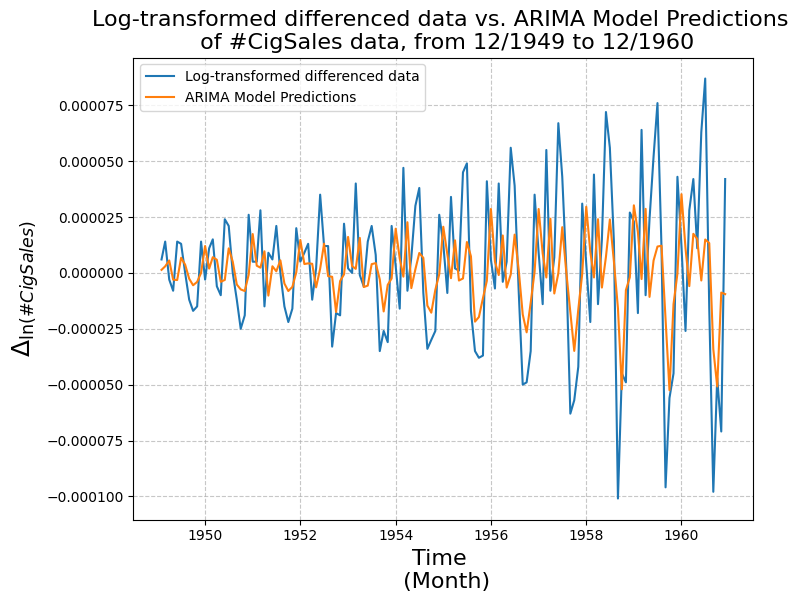

In [46]:
plt.figure(
    figsize=(8, 6)
)

# Log-transformed differenced data
plt.plot(
      np.log(y).diff().dropna()
    , label = 'Log-transformed differenced data'
)

# ARIMA model predictions
plt.plot(
      model_fit.predict()
    , label = 'ARIMA Model Predictions'
)

plt.title(
      'Log-transformed differenced data vs. ARIMA Model Predictions \n of #CigSales data, from 12/1949 to 12/1960'
    , size = 16
)

plt.xlabel(
      'Time \n (Month)'
    , size = 16
)

plt.ylabel(
      r'$\Delta_{\ln(\# CigSales)}$'
    , size = 18
)

plt.legend()

plt.grid(
      True
    , alpha     = 0.7
    , linestyle = '--'
)

plt.show()

### Conclusions

The plot suggests that the ARIMA model is a reasonable fit for the data, although there may be room for model improvement or the need for additional data or alternative models to capture the dynamics more accurately, especially in the latter part of the series.

## 4.6. Forecast

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

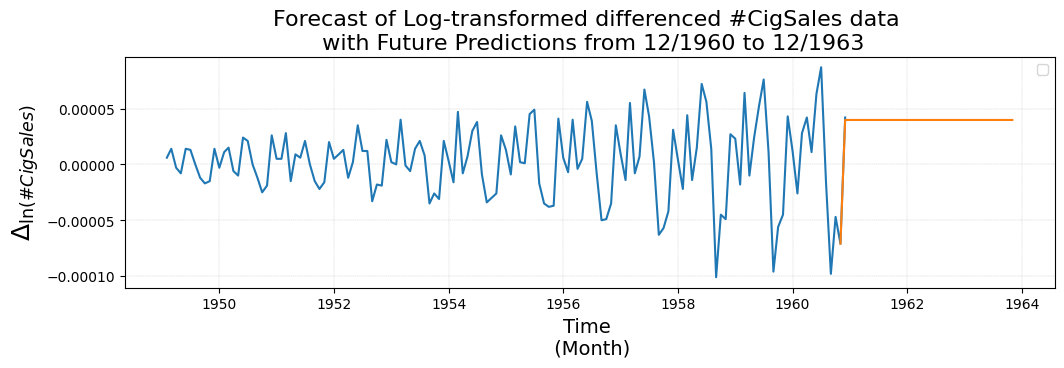

In [47]:
# Declare a variable called forecast_period with the amount of months to forecast, and

# Create a range of future dates that is the length of the periods we want
# to forecast (e.g., 36 months or from 01/12/1960 to 01/12/1963)
forecast_period = 36

date_range = pd\
            .date_range((np.log(y).diff().dropna()).index[-1], freq='MS', periods=forecast_period)\
            .strftime("%Y-%m-%d")\
            .tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(
      date_range
    , columns = ['Month']
)

# Let's now convert the 'Month' column to a datetime object with to_datetime
future_months['Month'] = pd.to_datetime(
    future_months['Month']
)

future_months.set_index(
      'Month'
    , inplace = True
)

future_months['Prediction'] = forecast[0]

# Plot future predictions
fig, ax = plt.subplots(
    figsize = (12, 3)
)

ax.grid(
      True
    , alpha     = 0.7
    , linestyle = '--'
    , linewidth = 0.3
)

ax.plot(
    np.log(y).diff().dropna()
)

ax.plot(
    (np.log(y).diff().dropna())['Nov 1960'].append(future_months['Prediction'])
)

plt.title(
     "Forecast of Log-transformed differenced #CigSales data \n with Future Predictions from 12/1960 to 12/1963"
    , size = 16
)

plt.xlabel(
      "Time \n (Month)"
    , size = 14
)

plt.ylabel(
      r'$\Delta_{\ln(\# CigSales)}$'
    , size = 18
)

plt.legend()

plt.show()

---

## 5. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors.

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one.